# DLToolboxImg: Part 2
A set of helper functions that one repeatedly need to construct a dataset from raw images, visualise the performance of a neural network while it is getting trained, evaluate the performance of a model after training is completed. 

As a running example, I will apply the functinos on the LIDC dataset.

# Table of Contents
- [Generate Dataset](#generatedata)
    - [Generate Positive Examples](#pos)
    - [Generate Negative Examples](#neg)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
from imports import *

<a id="generatedata"></a>
## Generate Dataset 

### Load the indices for train, valid, and test sets

In [3]:
root_dir="drive/"
interm_dir=root_dir+"interm5/"
filename=interm_dir+"scan_id_split"
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
    scan_id_train,scan_id_valid,scan_id_test=pickle.load(f)

In [4]:
scan_id_train,scan_id_valid,scan_id_test

([15, 16, 17, 20, 22, 23], [19], [18, 21, 14])

### Generate Positive Examples
<a id="pos"></a>

In [36]:
!mkdir /home/mas/x110/data/
!mkdir /home/mas/x110/data/pos
!mkdir /home/mas/x110/data/neg

mkdir: cannot create directory ‘/home/mas/x110/data/’: File exists
mkdir: cannot create directory ‘/home/mas/x110/data/pos’: File exists


In [42]:
interm_dir2='/home/mas/x110/data/pos'
interm_dir3='/home/mas/x110/data/neg'

In [8]:
#choose a scan
scan_id = scan_id_train[0]
scan_1 = ctscan(scan_id) 
scan_id

Loading dicom files ... This may take a moment.


15

In [8]:
#we would like to extract a 52x52x52 patch from the ctscan volume.
#The patch is centered at the noduel centroid
m = 52
cx,cy,cz = scan_1.centroids2[0]
cx,cy,cz

(115, 264, 93)

In [18]:
scan_1.zarrs

[array([92, 93, 94, 95, 96]),
 array([93, 94, 95, 96]),
 array([92, 93, 94, 95, 96]),
 array([92, 93, 94, 95, 96, 97])]

In [9]:
#grap the volume
image=scan_1.image_normalized #zxy
image.shape

(301, 421, 421)

In [10]:
cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)

In [11]:
cube_img.shape

(52, 52, 52)

<IPython.core.display.Javascript object>


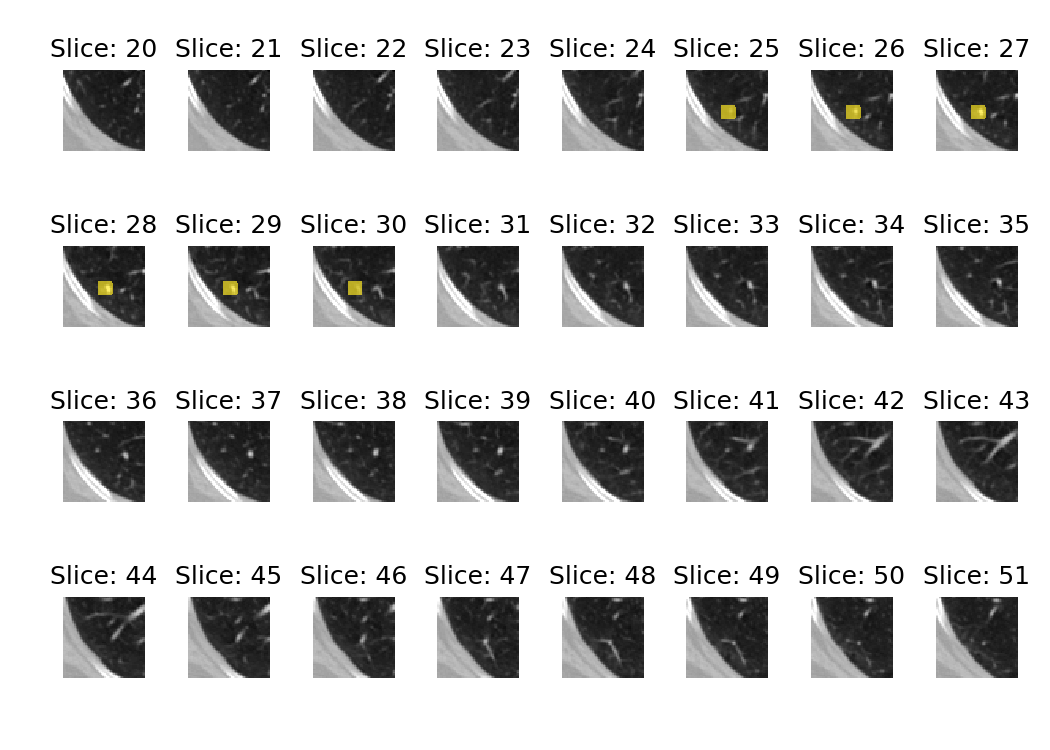

In [12]:
zs=32

X2 = cube_img.copy()
Z2=cube_label.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(7,5))

ind=np.arange(20,65)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("Slice: "+str(ii))
      
plt.tight_layout()

Now repeat the process on the full dataset

In [13]:
for scan_id in scan_id_train:#[xx+1:]:
    try:
        scan_1 = ctscan(scan_id) 
        m=52
        for cx,cy,cz in scan_1.centroids2:
            ### extract a cube with a centroid and size 32x32x32 for image
            image=scan_1.image_resampled #xyz
            image=image.swapaxes(2,1)
            image=image.swapaxes(0,1)
            cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
            cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)

            filename=intermdir2+'/data_P_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
    except:
        continue
                                                       
#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


### Generate Negative Examples
<a id="neg"></a>

1. get a scan
2. Apply the lung mask 
3. break the volume into patches serially
4. label each patch as pos (contains a nodue) or neg (does not include nodule)
5. The naming convention would be pos_scan_id_cx_cy_cz or neg_scan_id_cx_xy_cz

In [48]:
#choose a scan
scan_id = scan_id_train[0]
scan_1 = ctscan(scan_id) 
scan_id

Loading dicom files ... This may take a moment.


15

In [49]:
S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


In [50]:
S.shape

(301, 421, 421)

In [51]:
T = B.shape[1]**2

Areas=[np.sum(b)/T for b in B]

<IPython.core.display.Javascript object>


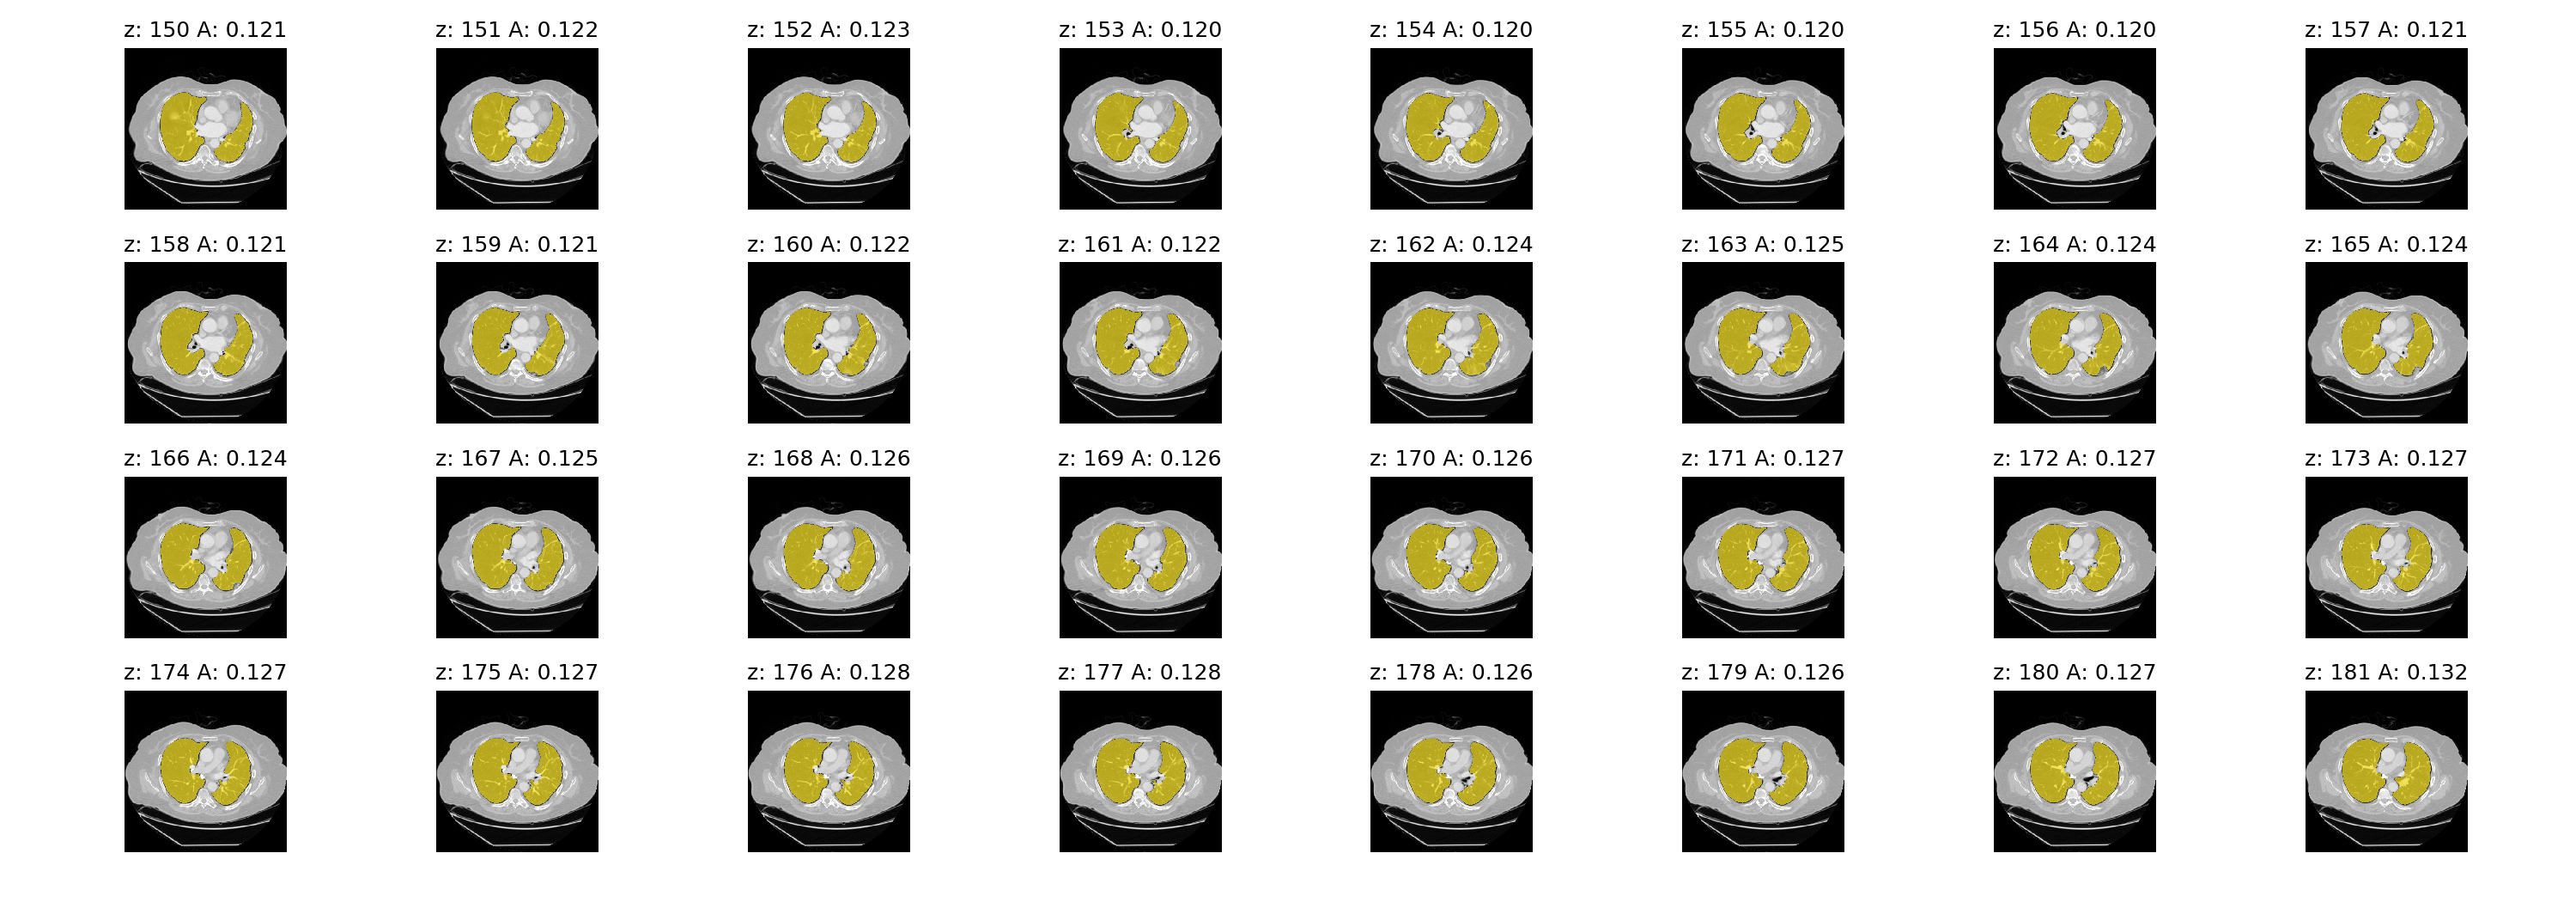

In [53]:
zs=32

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(150,301)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

<IPython.core.display.Javascript object>


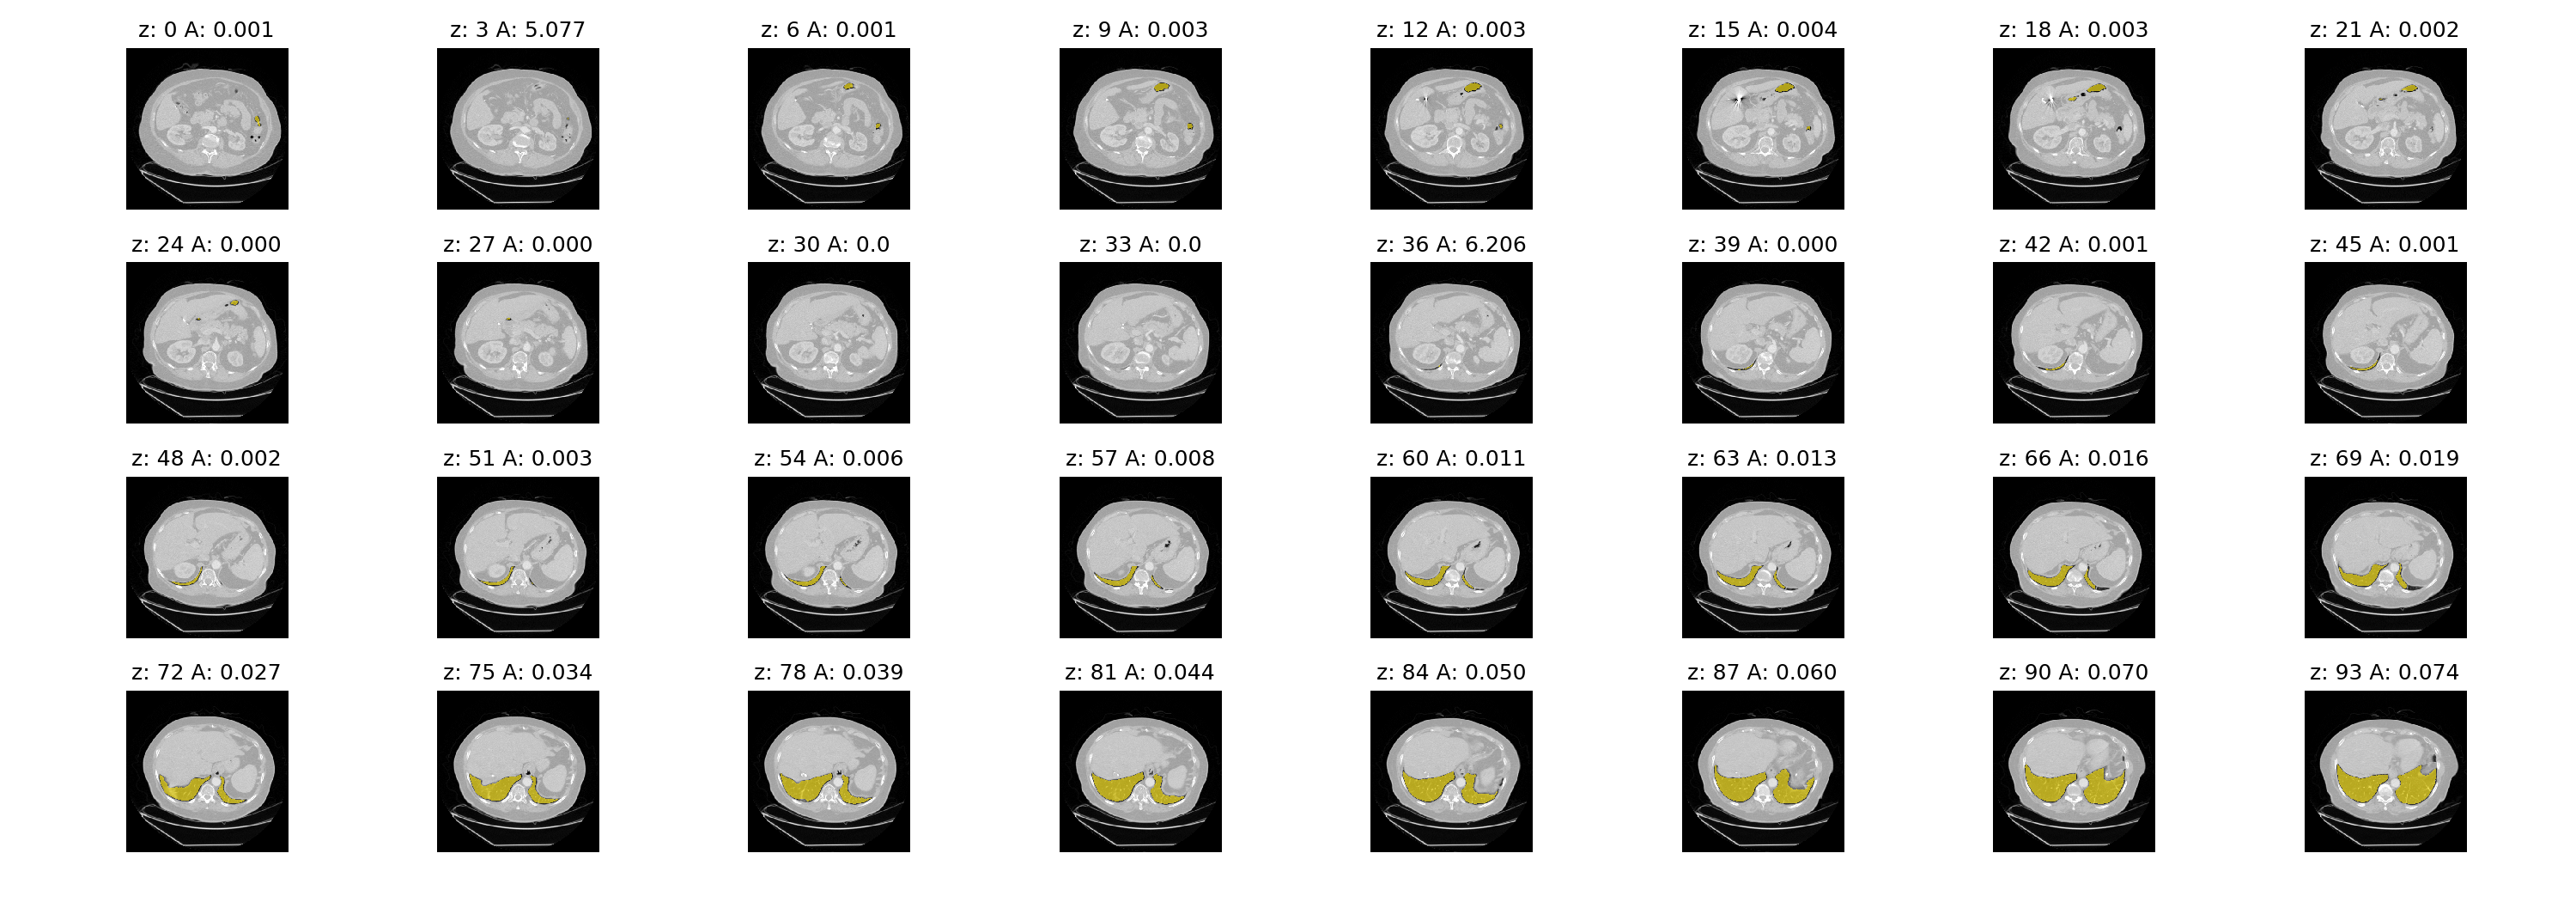

In [54]:
zs=32

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(0,150,3)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

<IPython.core.display.Javascript object>


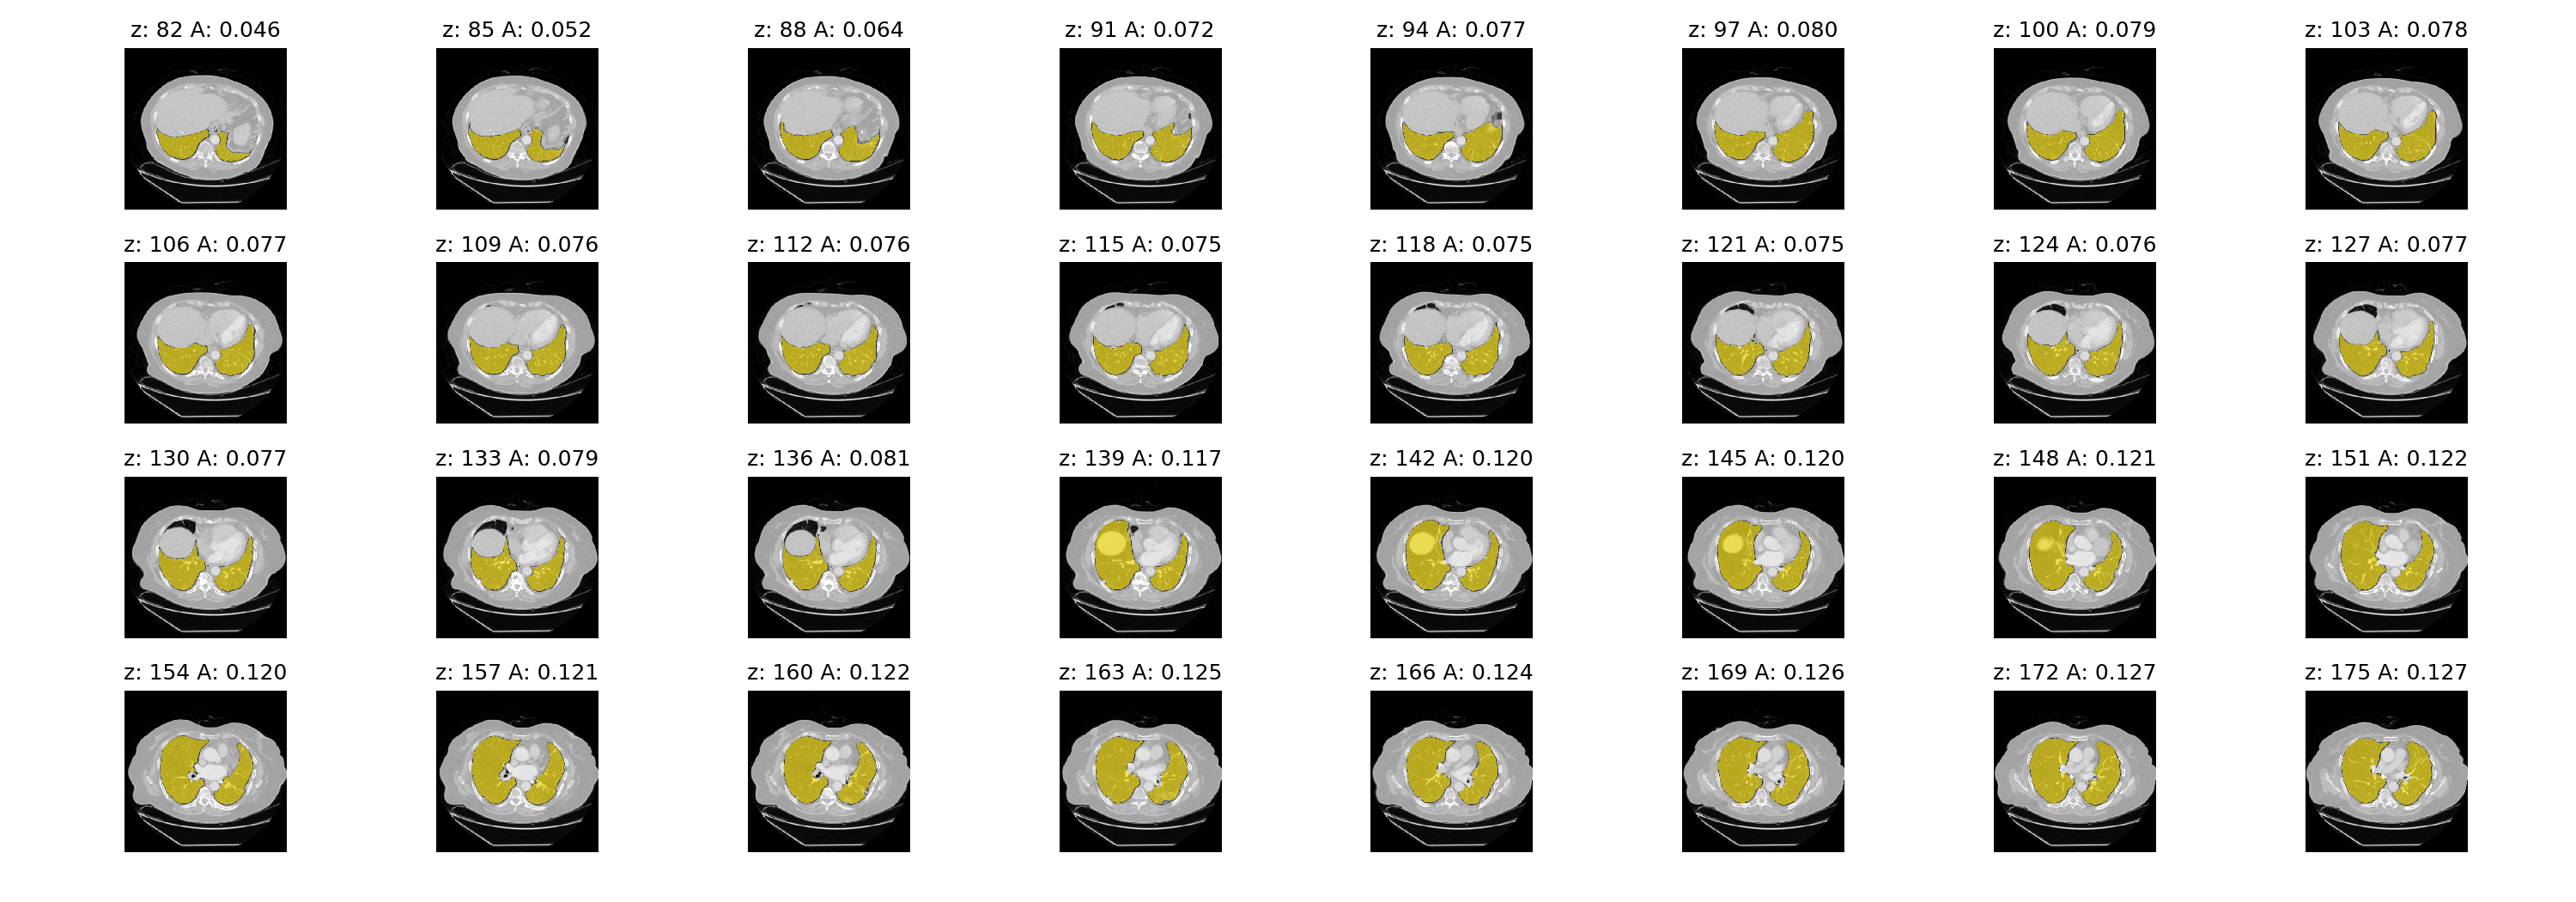

In [55]:
zs=32

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(82,300,3)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

In [56]:
ind2=[i for i,a in enumerate(Areas) if a>.02]

In [57]:
len(ind2)

197

We notice that the lung appears considerably in this scan when it occupies an area larger than .02

In [58]:
#look into the relation of nodule and slice location

In [59]:
zs=[]
for scan_id in scan_id_train:#[xx+1:]:
    scan_1 = ctscan(scan_id) 
    for cx,cy,cz in scan_1.centroids2:
        zs.append(cz)



Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


In [60]:
df=pd.DataFrame(zs,columns=['nodule_z_location'])

In [61]:
df.head()

nodule_z_location
0                 93
1                 95
2                 93
3                 95
4                192

<IPython.core.display.Javascript object>


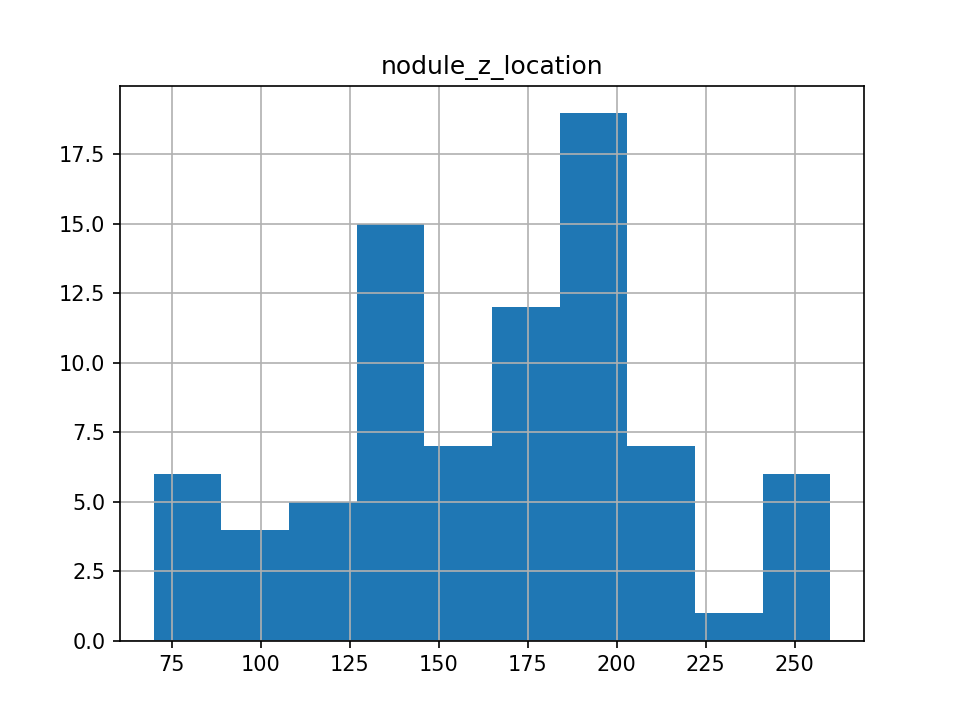

In [62]:
df.hist(column='nodule_z_location')
plt.show()

For this small sample of ctscans, we noticed that the nodule only appear after the 75th slice. No more nodues are found after 250

In [65]:
#choose a scan
scan_id = scan_id_train[0]
scan_1 = ctscan(scan_id) 
scan_id
S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

Loading dicom files ... This may take a moment.


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


<IPython.core.display.Javascript object>


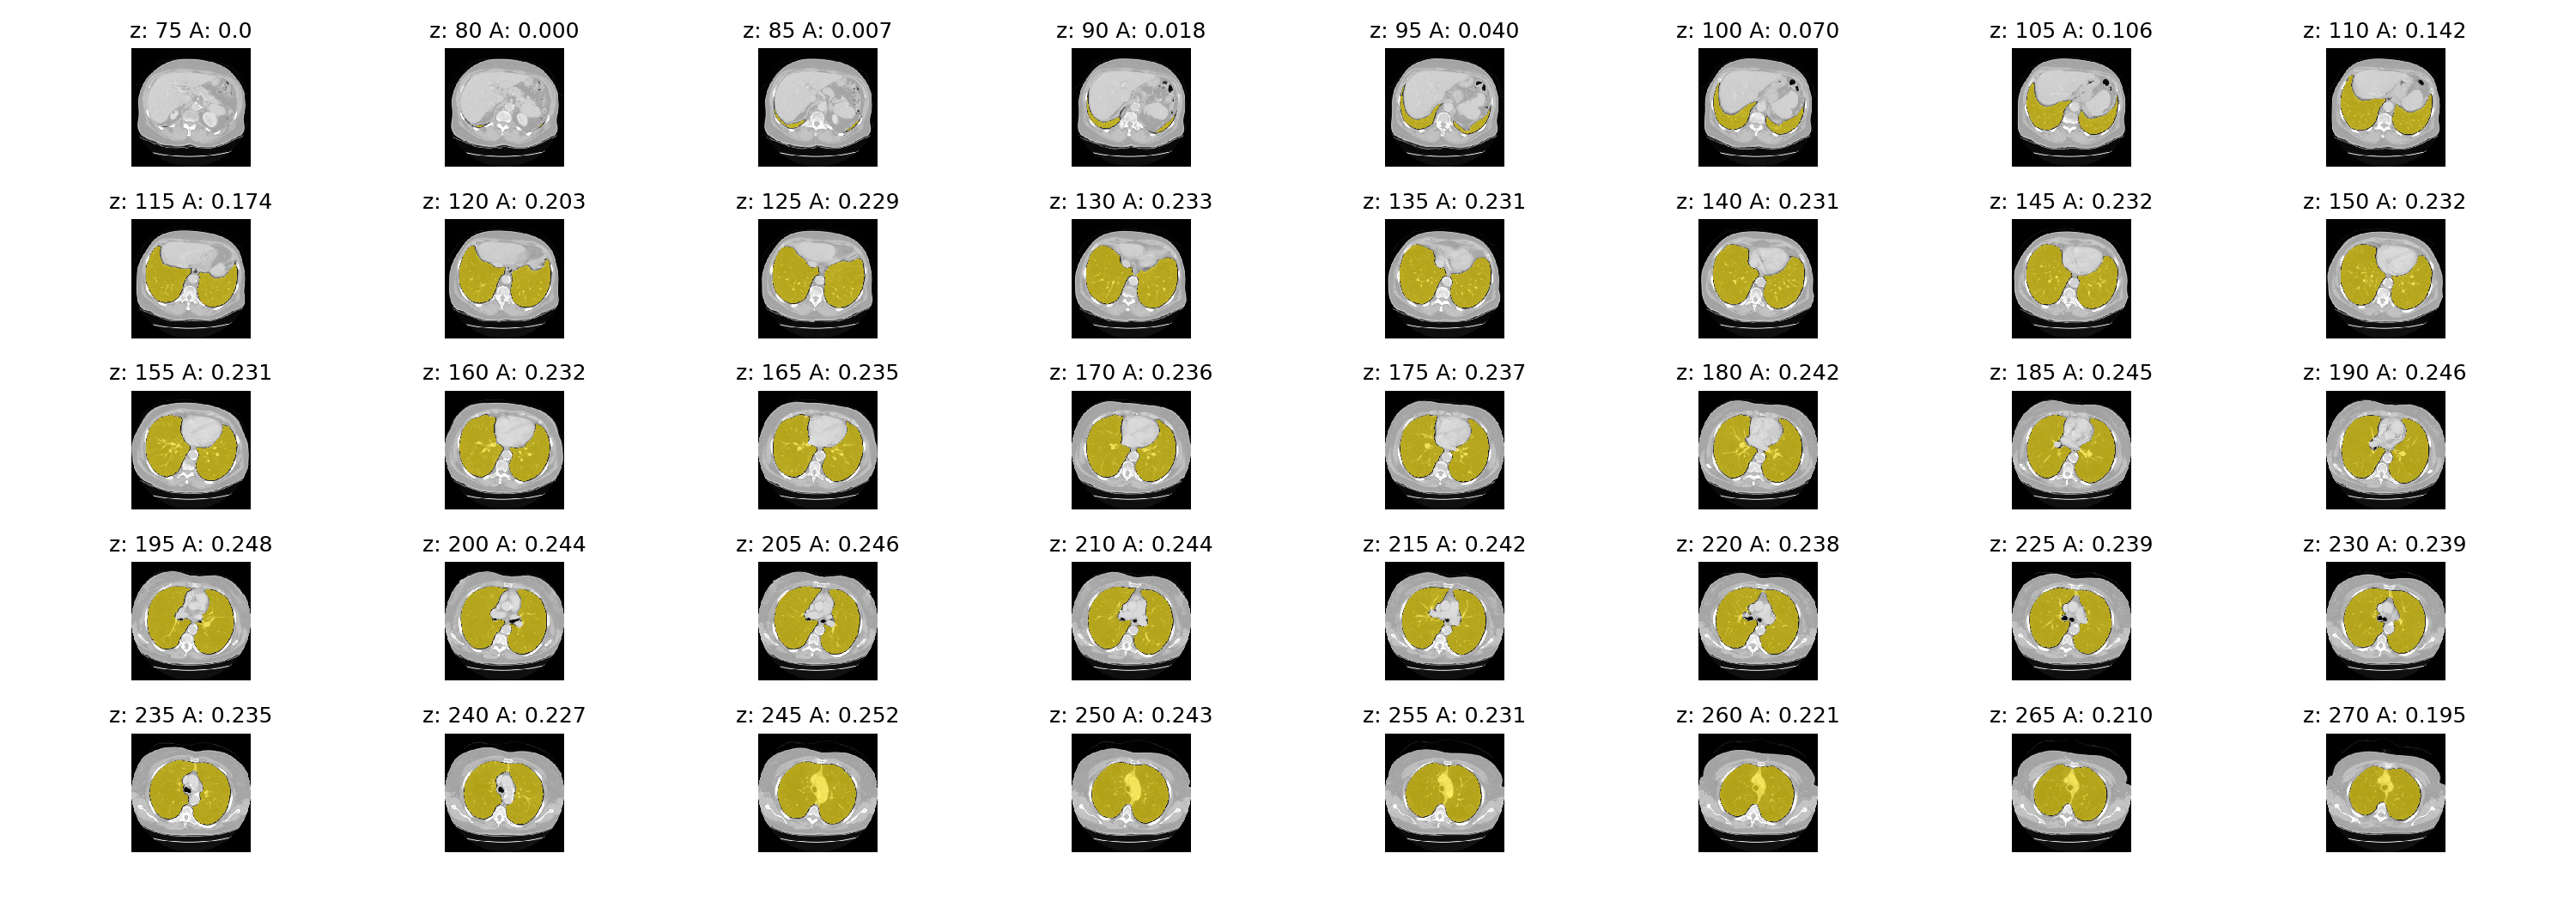

In [35]:
zs=40

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=5
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(75,300,5)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
    
      
plt.tight_layout()

In [68]:
#choose a scan
scan_id = scan_id_train[1]
scan_1 = ctscan(scan_id) 
scan_id
S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

Loading dicom files ... This may take a moment.


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


<IPython.core.display.Javascript object>


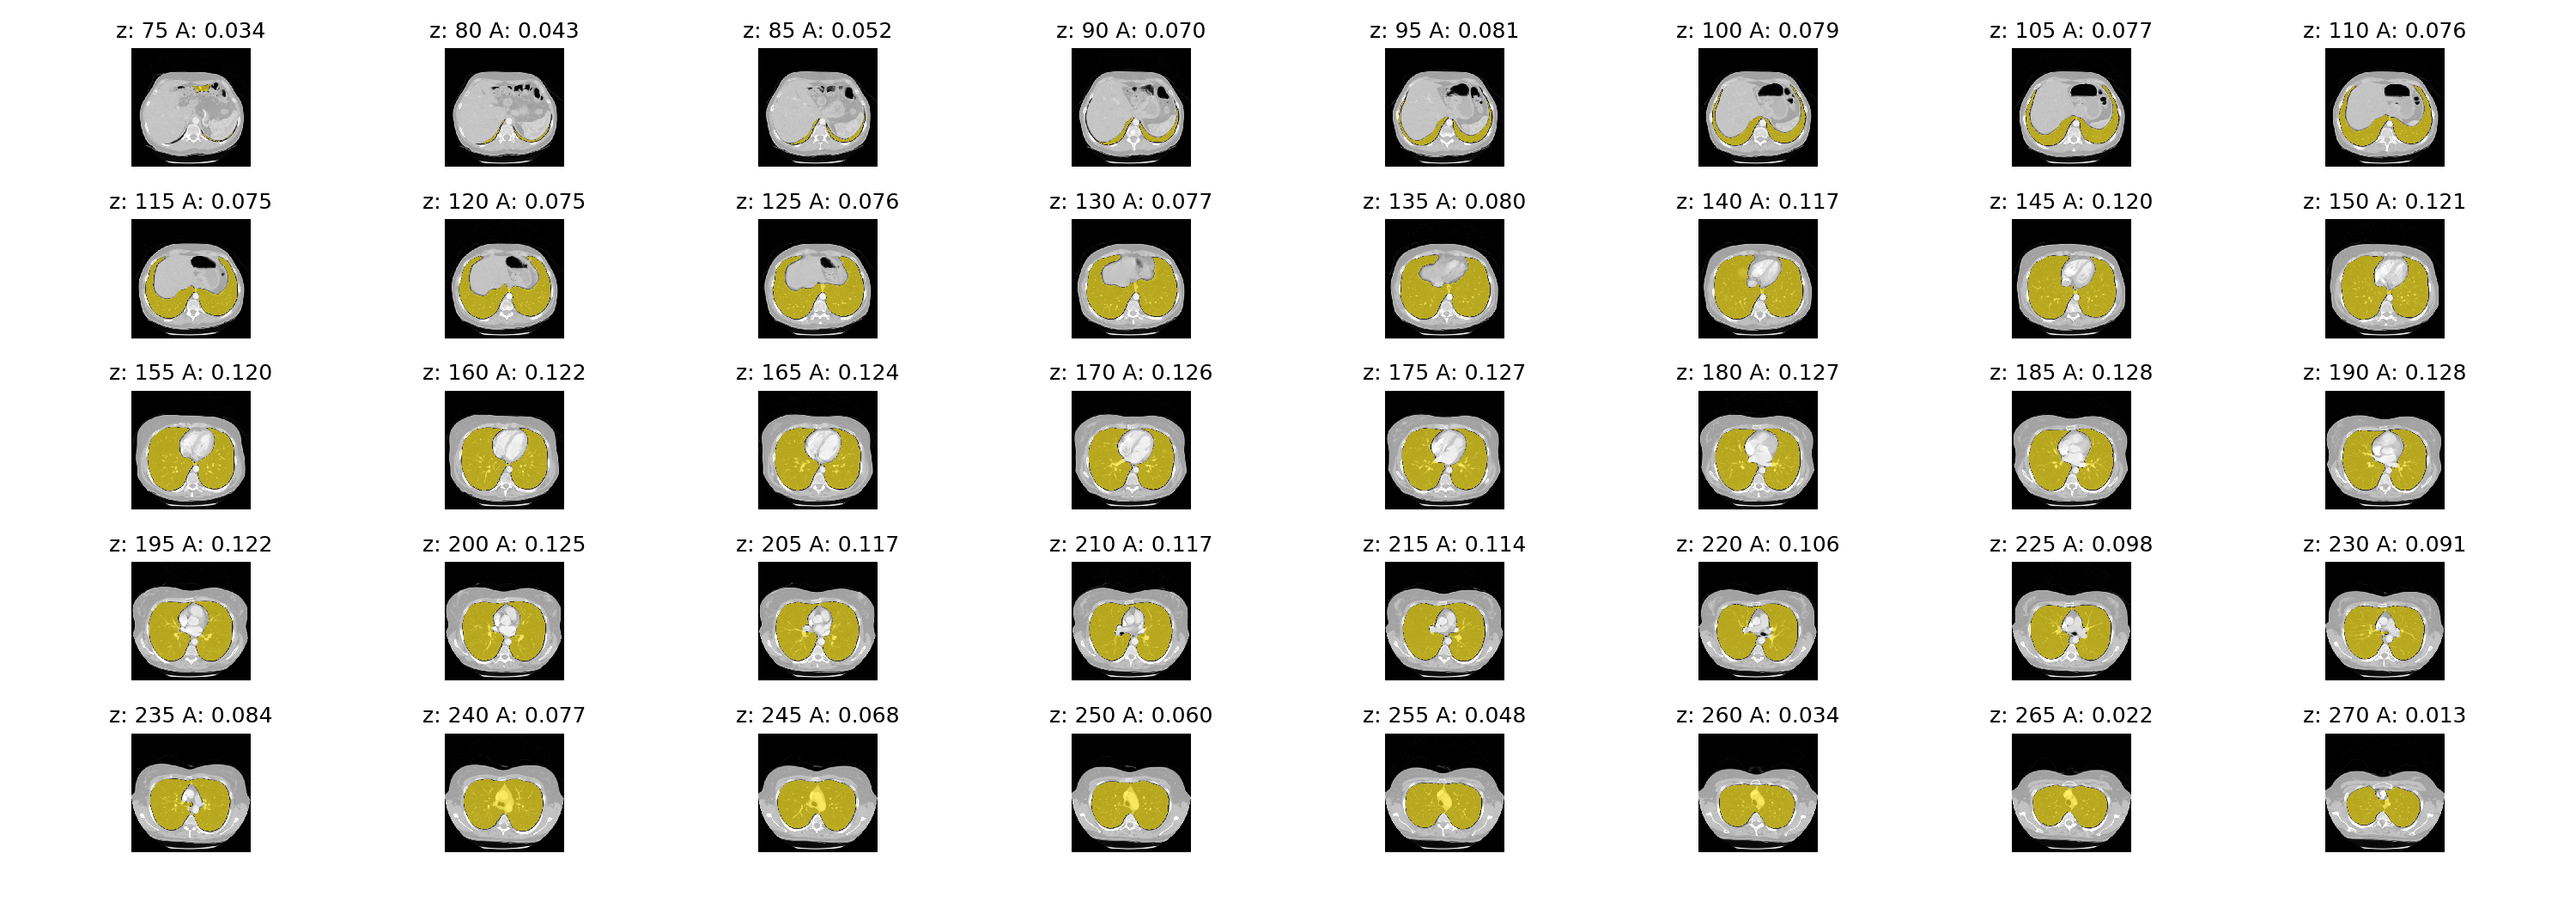

In [69]:
zs=40

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=5
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(75,300,5)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

In [70]:
B.shape

(332, 340, 340)

The z grid is not common among different scans. the 70th slice of one scn can be different to the 70th slice of another scan

In [7]:
#choose a scan
scan_id = scan_id_train[2]
scan_1 = ctscan(scan_id) 
scan_id
S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

Loading dicom files ... This may take a moment.


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


In [8]:
T = B.shape[1]**2
Areas=[np.sum(b)/T for b in B]

In [9]:
ind2=[i for i,a in enumerate(Areas) if a>.02]

In [13]:
z1,z2=ind2[0],ind2[-1]
z1,z2,z2-z1,B.shape[0]

(91, 313, 222, 332)

In [14]:
B.shape

(332, 320, 320)

In [15]:
#First randomly choose a z
zz=np.random.randint(z1,z2)
print(zz)
Bf=B[zz].flatten()
#In that slice, find the elements that are true
Cs=[i for i,e in enumerate(Bf) if e]

#randomly select an element from Cs
i = random.choice(Cs)
#from i get the original row and column of that element in B
a=B.shape[1];a
r = i//a
c=i-a*r

B[zz,r,c]
#Thus, we have succssfully selected a random point that resides inside the lung area

246


True

In [17]:
#we would like to extract a 52x52x52 patch from the ctscan volume.
#The patch is centered at the conditional random point we have generated
m = 32
cz,cy,cx =[zz,r,c]
#grap the volume
image=scan_1.image_normalized #zxy
cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)

In [19]:
zs=32

X2 = cube_img.copy()
Z2=cube_label.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(7,5))

ind=np.arange(0,32)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("Slice: "+str(ii))
      
plt.tight_layout()

<IPython.core.display.Javascript object>

To double check that we grapped the right postion, lets plot the random point in the full ctscan

<IPython.core.display.Javascript object>


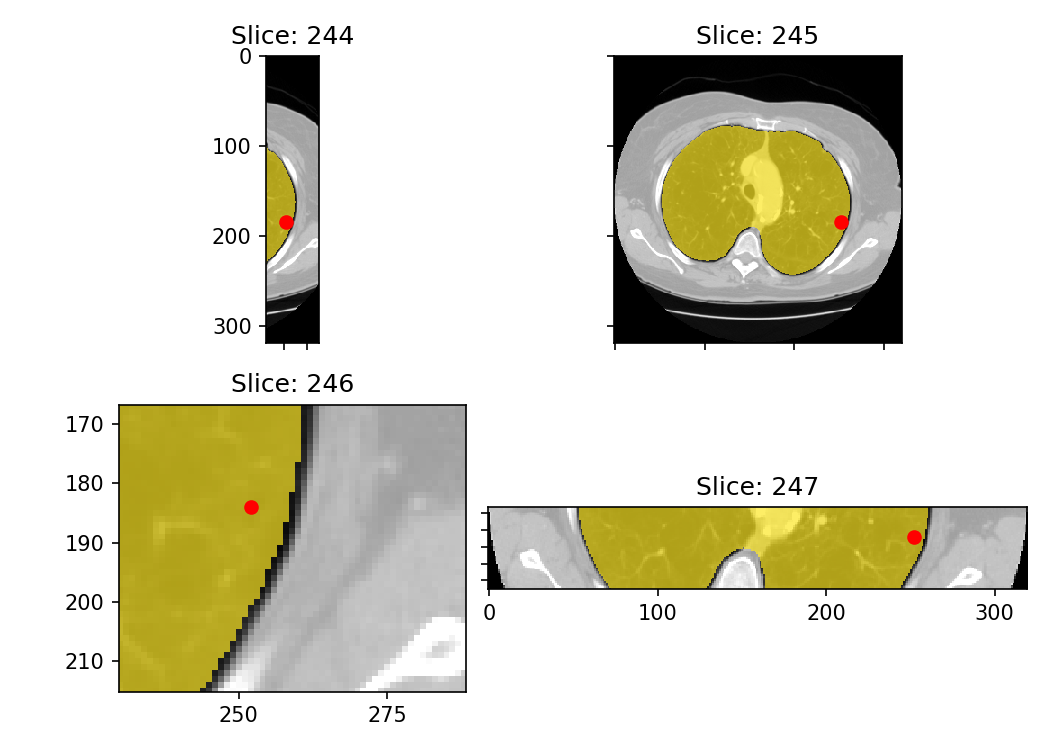

In [32]:
zs=4

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)


num_rows=2
num_cols=2

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(7,5))

ind=np.arange(zz-2,zz+2)
for i in range(zs):
    ii=ind[i]
    #plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("Slice: "+str(ii))
    plots[i // num_cols, i % num_cols].scatter(c,r, c='red', marker='o')

      
plt.tight_layout()

In [34]:
zz,r,c

(246, 184, 252)

Checked!

Now we need to generate more samples. lets say I will generate 100 samples.

In [48]:
random.seed(313)
for scan_id in scan_id_train:#[xx+1:]:
    scan_1 = ctscan(scan_id) 
    S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

    T = B.shape[1]**2
    Areas=[np.sum(b)/T for b in B]
    ind2=[i for i,a in enumerate(Areas) if a>.02]
    z1,z2=ind2[0],ind2[-1]

    for k in range(10):
        zz=np.random.randint(z1,z2)

        Bf=B[zz].flatten()
        #In that slice, find the elements that are true
        Cs=[i for i,e in enumerate(Bf) if e]
        #randomly select an element from Cs
        i = random.choice(Cs)
        #from i get the original row and column of that element in B
        a=B.shape[1];a
        r = i//a
        c=i-a*r

        #Thus, we have succssfully selected a random point that resides inside the lung area
        #we would like to extract a 52x52x52 patch from the ctscan volume.
        #The patch is centered at the conditioned random point we have generated
        m = 32
        cz,cy,cx =[zz,r,c]
        #grap the volume
        image=scan_1.image_normalized #zxy
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        if np.sum(cube_label)==0:
            #save file
            filename=interm_dir3+'/data_N_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
        else:
            k=k-1

#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

Loading dicom files ... This may take a moment.


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


## Read Negative Examples

In [51]:
import pandas as pd


if True:
    temp=!ls {interm_dir3} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])

    df['label']=0
    df['filename']=temp2
    df.to_csv(interm_dir3+"df_neg_scanid_centroid.csv")
else:
    df=pd.read_csv(interm_dir3+"df_neg_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(58, 6)


scan_id    x    y    z  label                   filename
0       15  181  261  164      0  data_N_15_181_261_164.pkl
1       15  178  183  233      0  data_N_15_178_183_233.pkl
2       15  262  276   77      0   data_N_15_262_276_77.pkl
3       15  102  246  130      0  data_N_15_102_246_130.pkl
4       15  282  226  237      0  data_N_15_282_226_237.pkl
5       15  183  182  131      0  data_N_15_183_182_131.pkl
6       15  160  188  205      0  data_N_15_160_188_205.pkl
7       15  296  223  117      0  data_N_15_296_223_117.pkl
8       15  297  202   95      0   data_N_15_297_202_95.pkl
9       15  324  220  158      0  data_N_15_324_220_158.pkl
10      16  116  211  296      0  data_N_16_116_211_296.pkl
11      16  222  164  270      0  data_N_16_222_164_270.pkl
12      16  264  150  157      0  data_N_16_264_150_157.pkl
13      16  215  253   91      0   data_N_16_215_253_91.pkl
14      16  125  252  103      0  data_N_16_125_252_103.pkl
15      16  284  235  124      0  data_N_16_284_235_124.pkl
16      16  167  200  153      0  data_N_16_167_200_153.pkl
17      16  113  165  250      0  data_N_16_113_165_250.pkl
18      16  119  193  218      0  data_N_16_119_193_218.pkl
19      17  266  135  182      0  data_N_17_266_135_182.pkl